In [1]:
import tensorflow as tf
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]=str("2")
print("Gogogo")

Gogogo


In [2]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [float(t) for t in l.split(",")]
        out.append(temp)
    F.close()
    return np.array(out)

PYR_targets = load("./DiPoppaData/Pyr_DiPoppa.csv")
PVAL_targets = load("./DiPoppaData/Pvalb_DiPoppa.csv")
SOM_targets = load("./DiPoppaData/SOM_DiPoppa.csv")
VIP_targets = load("./DiPoppaData/ViP_DiPoppa.csv")

data_names = ["Pyramidal","Parvalubin","ViP","Somatostatin"]

PYR_targets.shape

data = np.stack([PYR_targets,PVAL_targets,VIP_targets,SOM_targets],-1)
data = np.reshape(data,[2,10,2,4])

data_stim_size = data[:,:,0,0]
data_response = data[:,:,1,:]
data_arousal = np.stack([np.zeros_like(data[0,:,0,0]),np.ones_like(data[0,:,0,0])],0)

data_stim_size = np.float32(np.reshape(data_stim_size,[-1,1]))
data_arousal = np.float32(np.reshape(data_arousal,[-1,1]))
data_response = np.float32(np.reshape(data_response,[-1,4]))

print(data_response.shape)

(20, 4)


In [3]:
FF_input_scale = tf.exp(tf.Variable(np.zeros(4,dtype = np.float32),name = "feedforward_inp"))*np.float32(np.array([1,1,0,0]))
LAT_input_scale = tf.exp(tf.Variable(np.zeros(4,dtype = np.float32),name = "lateral_inp"))

#FB_input_scale = tf.exp(-tf.Variable(np.ones(4,dtype = np.float32),name = "feeedback_inp"))
FB_input_scale = tf.exp(tf.Variable(np.float32(np.log([12.8,24,8,9.6])-5),name = "feedback_inp"))
AR_input_scale = (tf.exp(tf.Variable(np.ones(4,dtype = np.float32),name = "arousal_inp")) - 1)*FB_input_scale

#FB_input_scale = 0.
#AR_input_scale = tf.exp(tf.Variable(np.ones(4,dtype = np.float32),name = "feeedback_inp"))

ff_lam = tf.exp(tf.Variable(np.float32(np.log(10.)),name = "feedforward_shape_parameter"))
lat_lam = tf.exp(tf.Variable(np.float32(np.log(10.)),name = "lateral_shape_parameter"))

input_size = tf.placeholder(tf.float32,shape = [data_response.shape[0],1])
input_arousal = tf.placeholder(tf.float32,shape = [data_response.shape[0],1])

In [4]:
def lat_input(R):
    return 1. - tf.exp(-tf.abs(R)/lat_lam)
    #return tf.nn.sigmoid(R - lat_lam)
def ff_input(R):
    return tf.erf(tf.abs(R)/ff_lam)

In [5]:

dt = .001
tau_E = .02
tau_I = .01

tau = np.float32(np.array([tau_E,tau_I,tau_I,tau_I]))

n = 2.2
k = tf.exp(tf.Variable(np.float32(np.log(.1)),trainable = True,name = "k"))

T = .2
nt = int(T/dt)

W = np.float32(np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]]))*tf.exp(tf.Variable(np.log(np.float32(np.array([[.017,.956,.045,.512],
              [.8535,.99,.09,.307],
              [2.104,.184,1,.734],
              [1.285,1,.14,1]]))) - 3,trainable = True,name = "W"))


In [6]:
MAX_RATE = 1000

def ssn_nonlinearity(V,n):
    return tf.pow(tf.clip_by_value(V,clip_value_min = 0,clip_value_max = MAX_RATE),n)

def get_next_SSN_state(state,A,lat_inp,ff_inp,W,k,n,tau,dt):
    ffI = ff_inp *  tf.expand_dims(FF_input_scale,0)
    laI = lat_inp * tf.expand_dims(LAT_input_scale,0)
    fbI = tf.expand_dims(FB_input_scale,0) + A * tf.expand_dims(AR_input_scale,0)
   
    Vi = tf.tensordot(state,W,axes = [[1],[1]]) + ffI + laI + fbI
    R = k*ssn_nonlinearity(Vi,n)

    
    return state + dt*(-state + R)/tf.expand_dims(tau,0)
    
init_state = tf.tile(0*input_size,(1,4))

states = tf.scan(lambda x,i: get_next_SSN_state(x,
                                              input_arousal,
                                              lat_input(input_size),
                                              ff_input(input_size),
                                              W,
                                              k,
                                              n,
                                              tau,
                                              dt),
                 tf.range(nt),init_state)
states = tf.transpose(states,[1,0,2])
print(states.shape)
                     

(20, 200, 4)


In [7]:
test_time = .1
test_nt = int(test_time/dt)

test_frac = .1
test_num = int(test_frac * int(states.shape[0] * states.shape[2]))

target_rates = tf.placeholder(tf.float32,(None,4))



all_indices = np.reshape(np.array([[(k,i) for i in range(states.shape[2])] for k in range(states.shape[0])]),[-1,2])
test_indices = all_indices[np.random.choice(range(len(all_indices)),test_num)]

test_mask = np.zeros([states.shape[0],test_nt,states.shape[2]])
print(test_mask.shape)
for k in test_indices:
    test_mask[k[0],:,k[1]] = 1
test_mask = np.int32(test_mask)
train_mask = np.int32(1 - test_mask)

loss = tf.reduce_mean(tf.boolean_mask(tf.expand_dims(target_rates,1) - states[:,-test_nt:],train_mask)**2)
test_loss = tf.reduce_mean(tf.boolean_mask(tf.expand_dims(target_rates,1) - states[:,-test_nt:],test_mask)**2)
adam = tf.train.AdamOptimizer(learning_rate = .01)
train = adam.minimize(loss)


(20, 100, 4)


[[ 0.00084638 -0.04759643 -0.00224042 -0.02549098]
 [ 0.04249326 -0.0492892  -0.00448084 -0.01528463]
 [ 0.10475198 -0.00916082  0.         -0.0365437 ]
 [ 0.06397638  0.         -0.00697019  0.        ]]
(2, 10, 4)


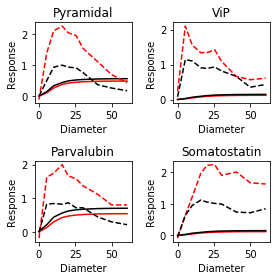

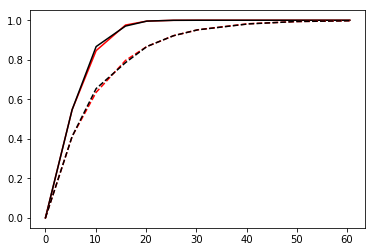

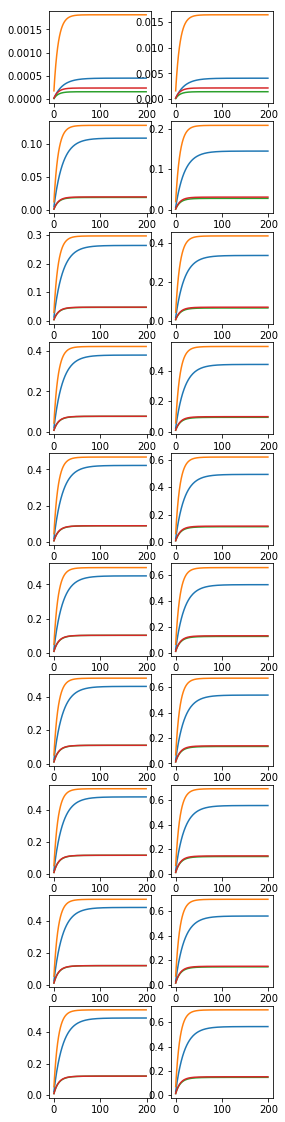

In [8]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

responses,latin,ffin,ww = sess.run([states,lat_input(input_size),
                                              ff_input(input_size),W],{input_arousal:data_arousal,input_size:data_stim_size})

print(ww)
OUT = np.mean(np.reshape(responses[:,-test_nt:],[2,10,-1,4]),axis = 2)
print(OUT.shape)
true_resp = np.reshape(data_response,[2,10,4])

latin = np.reshape(latin,[2,10])
ffin = np.reshape(ffin,[2,10])

import matplotlib.pyplot as plt

fig,sub = plt.subplots(2,2,figsize = (4,4))

for i in range(2):
    for j in range(2):
        sub[i,j].plot(data_stim_size[:10],OUT[0,:,i + 2*j],"r")
        sub[i,j].plot(data_stim_size[:10],OUT[1,:,i + 2*j],"k")
        
        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"r--")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"k--")
        sub[i,j].set_title(data_names[i+2*j])
        sub[i,j].set_xlabel("Diameter")
        sub[i,j].set_ylabel("Response")


plt.tight_layout()
plt.show()

plt.plot(data_stim_size[:10],ffin[0,:],"r")
plt.plot(data_stim_size[:10],ffin[1,:],"k")
plt.plot(data_stim_size[:10],latin[0,:],"r--")
plt.plot(data_stim_size[:10],latin[1,:],"k--")
plt.show()
sess.close()

fig,sub = plt.subplots(10,2,figsize = (4,20))

for k in range(10):
    for j in range(2):
        sub[k][j].plot(responses[k + j*10])
plt.show()

In [9]:
variables = tf.trainable_variables()
vnames = [v.name for v in variables]

print(vnames)

['feedforward_inp:0', 'lateral_inp:0', 'feedback_inp:0', 'arousal_inp:0', 'feedforward_shape_parameter:0', 'lateral_shape_parameter:0', 'k:0', 'W:0']


In [10]:
init = tf.global_variables_initializer()
#config = tf.ConfigProto(device_count = {'GPU': 1})
#sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

tl = 1000

print("step\ttrain_loss\ttest_loss")
for k in range(1000):
    _,train_loss,test_eval = sess.run([train,loss,test_loss],{input_arousal:data_arousal,input_size:data_stim_size,target_rates:data_response})
    if k%10 == 0:
        print("{}\t{}\t{}".format(k,train_loss,test_eval))
    if test_eval < tl:
        tl = test_eval
        goodpar = sess.run(variables)


step	train_loss	test_loss
0	1.0379115343093872	0.41905876994132996
10	0.9216692447662354	0.38254958391189575
20	0.8084616661071777	0.35713428258895874
30	0.7042074799537659	0.3110445737838745
40	0.5896399021148682	0.2426815629005432
50	0.4799690544605255	0.23307344317436218
60	0.41724729537963867	0.2855472266674042
70	0.378836452960968	0.2577301263809204
80	0.3508763015270233	0.2197486162185669
90	0.33147087693214417	0.21413666009902954
100	0.3181418776512146	0.21544264256954193
110	0.30837884545326233	0.21183229982852936
120	0.3009265959262848	0.20913851261138916
130	0.29504650831222534	0.20714539289474487
140	0.29027602076530457	0.2056737095117569
150	0.28633132576942444	0.2050047516822815
160	0.2830062806606293	0.2038990557193756
170	0.28015461564064026	0.2029293030500412
180	0.2776656150817871	0.20225663483142853
190	0.27545469999313354	0.20149679481983185
200	0.2734543979167938	0.20076127350330353
210	0.2716090679168701	0.2000279426574707
220	0.2698710858821869	0.19927971065044403

In [11]:
responses = sess.run(states,{input_arousal:data_arousal,input_size:data_stim_size})

parameters = sess.run(variables)

sess.close()

In [27]:
print(responses.shape)

print(test_indices)

(20, 200, 4)
[[13  0]
 [17  2]
 [18  1]
 [19  2]
 [11  0]
 [ 0  0]
 [ 5  2]
 [15  2]]


In [13]:
OUT = np.mean(np.reshape(responses[:,-test_nt:],[2,10,-1,4]),axis = 2)
print(OUT.shape)
true_resp = np.reshape(data_response,[2,10,4])

(2, 10, 4)


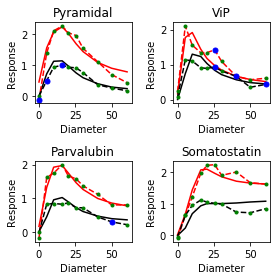

In [41]:
import matplotlib.pyplot as plt

fig,sub = plt.subplots(2,2,figsize = (4,4))

for i in range(2):
    for j in range(2):
        sub[i,j].plot(data_stim_size[:10],OUT[0,:,i + 2*j],"r")
        sub[i,j].plot(data_stim_size[:10],OUT[1,:,i + 2*j],"k")
        
        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"r--")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"k--")

        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"g.")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"g.")
        sub[i,j].set_title(data_names[i+2*j])
        sub[i,j].set_xlabel("Diameter")
        sub[i,j].set_ylabel("Response")

for i in test_indices:
    sub[i[1]%2,int(np.floor(i[1]/2))].plot(data_stim_size[i[0]%10],true_resp[int(np.floor(i[0]/10)),i[0]%10,i[1]],"b.",markersize = 10)

plt.tight_layout()
plt.savefig("./initial_multi_cell_fit.pdf",bbox_inches = "tight")
plt.show()

In [15]:
import utilities as utils 

utils.dump_file("./parameter_file",parameters)
utils.dump_file("./parameter_names",vnames)

In [16]:
parameters[-1]

array([[ 0.6690641 , -4.274083  , -0.24992016,  0.4800571 ],
       [ 0.09425295, -4.029568  , -2.941453  , -0.31016314],
       [ 0.6343313 , -5.686372  , -3.        ,  0.54285175],
       [-0.3157218 , -3.        , -5.0252786 , -3.        ]],
      dtype=float32)

In [17]:
np.round(np.float32(np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]]))*np.exp(parameters[-1]),2)

array([[ 1.95, -0.01, -0.78, -1.62],
       [ 1.1 , -0.02, -0.05, -0.73],
       [ 1.89, -0.  ,  0.  , -1.72],
       [ 0.73,  0.  , -0.01,  0.  ]], dtype=float32)

In [18]:
np.array([[1,-1,-1,-1]])*np.array([
[.017,.956,.045,.512],
[.8535,.99,.09,.307],
[2.104,.184,0,.734],
[1.285,0,.14,0]
])

array([[ 0.017 , -0.956 , -0.045 , -0.512 ],
       [ 0.8535, -0.99  , -0.09  , -0.307 ],
       [ 2.104 , -0.184 , -0.    , -0.734 ],
       [ 1.285 , -0.    , -0.14  , -0.    ]])

In [19]:
vnames

['feedforward_inp:0',
 'lateral_inp:0',
 'feedback_inp:0',
 'arousal_inp:0',
 'feedforward_shape_parameter:0',
 'lateral_shape_parameter:0',
 'k:0',
 'W:0']

In [20]:
print(np.exp(parameters[-4]))
print(np.exp(parameters[-3]))

11.494526
19.92029


In [21]:
print(np.exp(parameters[-2]))

0.23552758


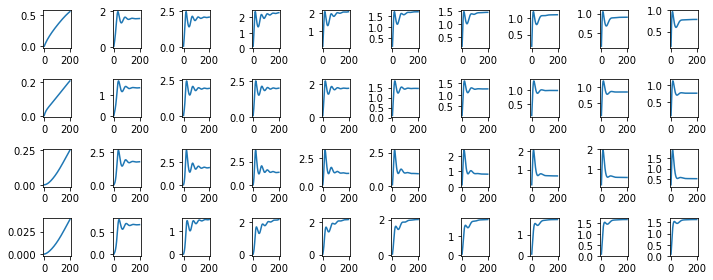

In [42]:
import matplotlib.pyplot as plt

fig,sub = plt.subplots(4,10,figsize = (10,4))

for i in range(10):
    for k in range(4):
        sub[k,i].plot(responses[i,:,k])
plt.tight_layout()
plt.savefig("./response_time_course.pdf")
plt.show()

In [23]:
print(responses.shape)

(20, 200, 4)
